In [6]:
from datasets import load_dataset
import torch
import os
import pickle
import random
random.seed(1330) 
import regex as re
from tokenizer import RegExpTokenizer


name = ""

ds = load_dataset("statworx/haiku")
haikutext = '\n'.join(ds['train']['text'])
vocab_size = 1000
tokenizer = RegExpTokenizer()
tokens = tokenizer.encode(haikutext, vocab_size, verbose=False)


In [7]:
data = torch.tensor(tokens, dtype=torch.long)

#train test split
n = int(0.80*len(data)) # first 80% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# Model Train

In [8]:
# hyperparameters

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu") #m1 gpu
batch_size = 64 # how many independent sequences will we process in parallel
block_size = 256 # what is the maximum context length for predictions
max_iters = 10000 # epochs/learning iterations
eval_interval = 100 # for printing loss updates
checpoint_interval = 1000 #save checkpoint
learning_rate = 3e-4 # Slower learning rate for wide model
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
n_block_layers = 6
dropout = 0.2

In [13]:
from BigramLanguageModelTrain import utilTools as ut
from BigramLanguageModelTrain import BigramLanguageModel


#Relearning Epoch starting point
iterationStart = 21000


#Stopping criteria parameters
patience = 8
best_val_loss = float('inf')
epochs_no_improve = 0


util_tools = ut(train_data, val_data, block_size, batch_size, device)
model = BigramLanguageModel(block_size, vocab_size, n_embd, n_head, dropout, device)

if os.path.exists(f'.losses{name}/trainlosses_{iterationStart}.pkl'):
    with open(f'.losses{name}/trainlosses_{iterationStart}.pkl', "rb") as file:
        trainlosses = pickle.load(file)
else:
    trainlosses = []

if os.path.exists(f'.losses{name}/vallosses_{iterationStart}.pkl'):
    with open(f'.losses{name}/vallosses_{iterationStart}.pkl', "rb") as file:
        vallosses = pickle.load(file)
else:
    vallosses = []


if os.path.exists(f'./model_weights{name}/model_weights_{iterationStart}.pth'):
    print("Loading from previous checkpoint", f"'./model_weights{name}/model_weights_{iterationStart}.pth'")
    # Load previous weights
    model.load_state_dict(torch.load(f'./model_weights{name}/model_weights_{iterationStart}.pth', weights_only=True))

m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = util_tools.estimate_loss(model, eval_iters)
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        trainlosses.append(losses['train'])
        vallosses.append(losses['val'])

        #Stopping Criteria
        if losses['val'] < best_val_loss:
            best_val_loss = losses['val']
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        
        if epochs_no_improve >= patience:
            print("Early stopping")
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            break
    if iter % checpoint_interval ==0 and iter >0:
        # Save the weights checkpoint
        torch.save(model.state_dict(), f"./model_weights{name}/model_weights_{iter+iterationStart}.pth")

    # sample a batch of data
    xb, yb = util_tools.get_batch(split ='train')
    xb, yb = xb.to(device), yb.to(device)


    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
print("Train complete")
# Save the weights
torch.save(model.state_dict(), f"./model_weights{name}/model_weights_{iter+iterationStart}.pth")
with open(f"./losses{name}/trainlosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(trainlosses, file)
with open(f"./losses{name}/vallosses_{iter+iterationStart}.pkl", "wb") as file:
    pickle.dump(vallosses, file)

Loading from previous checkpoint './model_weightsRegexToken/model_weights_21000.pth'
6.188008 M parameters
step 0: train loss 1.5831, val loss 2.3087
step 100: train loss 1.5653, val loss 2.2960
step 200: train loss 1.5691, val loss 2.2832
step 300: train loss 1.5660, val loss 2.2642
step 400: train loss 1.5616, val loss 2.2905
step 500: train loss 1.5559, val loss 2.2844
step 600: train loss 1.5507, val loss 2.2833
step 700: train loss 1.5494, val loss 2.2646
step 800: train loss 1.5450, val loss 2.2776
step 900: train loss 1.5387, val loss 2.2832
step 1000: train loss 1.5385, val loss 2.2724
step 1100: train loss 1.5356, val loss 2.2679
Early stopping
step 1100: train loss 1.5356, val loss 2.2679
Train complete


In [14]:
def load_pkl_file(file_path):
    with open(file_path, 'rb') as file:
        return list(pickle.load(file))
    
trainlossfile = sorted([item for item in os.listdir(f'./losses{name}') if 'train' in item])
vallossfile = sorted([item for item in os.listdir(f'./losses{name}') if 'val' in item])
traininglosses = []
vallosses = []
for i in range(0, len(trainlossfile)):
    traininglosses.extend(load_pkl_file(f'./losses{name}/{trainlossfile[i]}'))
    vallosses.extend(load_pkl_file(f'./losses{name}/{vallossfile[i]}'))

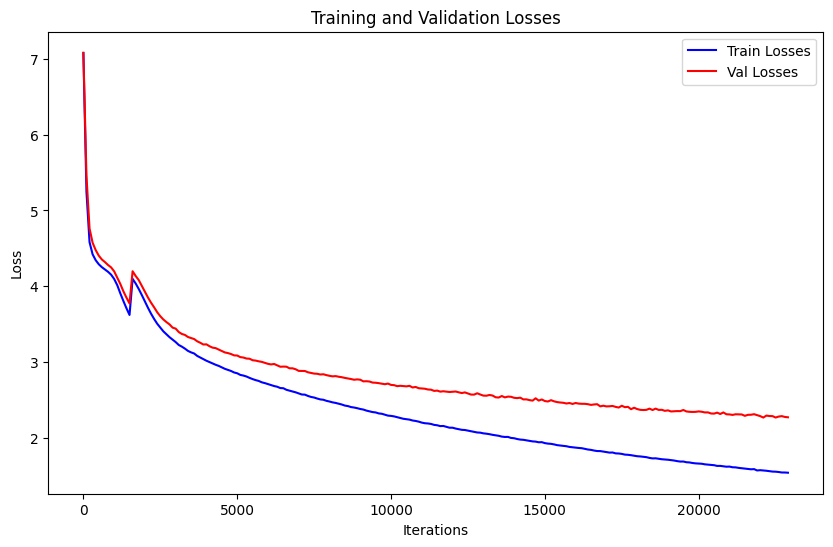

In [15]:
import matplotlib.pyplot as plt
# Create the plot
x_values = list(range(0,len(traininglosses)*100,100))
plt.figure(figsize=(10, 6))

# Plot the training losses
plt.plot(x_values, traininglosses, label='Train Losses', color='blue')
# Plot the validation losses
plt.plot(x_values, vallosses, label='Val Losses', color='red')
# Add labels and title
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
# Add a legend
plt.legend()
# Show the plot
plt.show()